## Plate Velocities

This notebook goes through a series of examples for how to use pygplates to work with plate velocities.

This tutorial goes through the following use cases:
- getting the velocity for a single plate, at a single point, for a single time
- different velocity forms - magnitude/azimuth versus north/east vector components
- getting the velocity for a series of times
- calculating and plotting the convergence velocity (and obliquity) between two plates


#### Velocity Basics

The basic requirements to calculate any plate velocities are:
  - a rotation file containing Euler poles defining plate motions
  - the plateid(s) that define the moving plate (and the frame of reference)
  - a time range over which to determine the velocity
  - the geographic location of the point where we evaluate velocity
  
The first example illustrates these concepts:
  1. First, we load the rotation model from the Seton et al (2012) dataset
  2. Second, we get the stage rotation that describes how the plate 101 (North America) is moving over the time period between 11 Ma and 10 Ma. [Note that since don't specify which plate North America is moving relative to, this calculation will default to getting the velcocity relative to the absolute reference frame in the rotation file]
  3. 


In [1]:
import pygplates
import numpy as np


0.0 8.01691849293 77.6775203432
5.0 7.9825110935 78.6586164351
10.0 9.52931100193 87.7696596371
15.0 9.88449140404 89.294958951
20.0 9.67915161715 83.3750007575
25.0 10.0766316146 68.8426276906
30.0 7.98762813749 68.4742869018
35.0 4.65357712225 74.4527234479
40.0 9.50200623055 81.8490828129
45.0 8.53708857733 89.5049654347
50.0 7.38096474356 108.647595937
55.0 1.94242257641 87.6675355488
60.0 2.5098440142 47.0654337901
65.0 5.51946411102 47.7610847017
70.0 5.98258099439 51.3928396733
75.0 3.27490697671 9.18561848507
80.0 4.24450455296 46.544913443
85.0 12.2850875876 77.8522056787
90.0 10.2086194828 69.1261492387
95.0 9.5464186728 46.1866454524


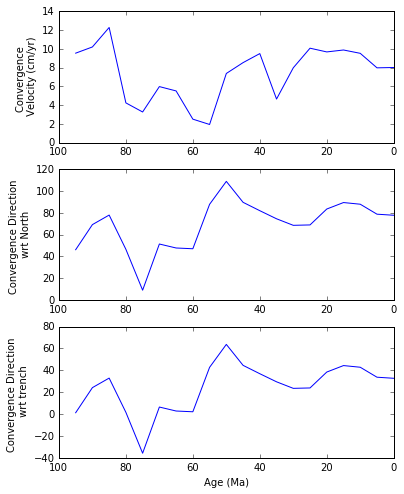

In [2]:
# Rotation File
rotation_filename = '/Users/Simon/GIT/pygplates-alpha/tutorials-sv/Data/Seton_etal_ESR2012_2012.1.rot'

# Point at which to calculate convergence (assuming over-riding plate is fixed)
point_longitude = -71
point_latitude = -20

# Plate pair sharing convergent boundary. fixed plate --> over-riding plate
fixed_plate = 201
moving_plate = 902

# Time range and time increment for convergence velocity calculation
min_time = 0.
max_time = 100.
time_step = 5.

trench_strike = -45.

####### END OF USER INPUT
time_array = np.arange(min_time,max_time,time_step)

rotation_model = pygplates.RotationModel(rotation_filename)

velocity_point = pygplates.PointOnSphere((point_latitude,point_longitude))

velocity_magnitude = []
velocity_azimuth = []

for time in time_array:
    # Get the rotation for current time interval, and the feature's reconstruction plate ID.
    equivalent_stage_rotation = rotation_model.get_rotation(
        time, moving_plate, time+time_step, fixed_plate)

    # Calculate a velocity for each reconstructed point over the 1My time interval.
    velocity_vector = pygplates.calculate_velocities(
        velocity_point,
        equivalent_stage_rotation,
        time_step,
        pygplates.VelocityUnits.cms_per_yr)

    velocity_magnitude_azimuth = pygplates.LocalCartesian.convert_from_geocentric_to_magnitude_azimuth_inclination(
                            velocity_point,
                            velocity_vector)

    #print velocity_vector
    print time, velocity_magnitude_azimuth[0][0], np.degrees(velocity_magnitude_azimuth[0][1])
    velocity_magnitude.append(velocity_magnitude_azimuth[0][0])
    velocity_azimuth.append(np.degrees(velocity_magnitude_azimuth[0][1]))


import matplotlib.pyplot as plt

%matplotlib inline
plt.figure(figsize=(6,8))
plt.subplot(311)
plt.plot(time_array,velocity_magnitude)
plt.xlim([100,0])
plt.ylabel('Convergence \n Velocity (cm/yr)')
plt.subplot(312)
plt.plot(time_array,velocity_azimuth)
plt.xlim([100,0])
plt.ylabel('Convergence Direction \n wrt North')
plt.subplot(313)
plt.plot(time_array,np.array(velocity_azimuth)-trench_strike-90)
plt.xlim([100,0])
plt.ylabel('Convergence Direction \n wrt trench')
plt.xlabel('Age (Ma)')
plt.show()




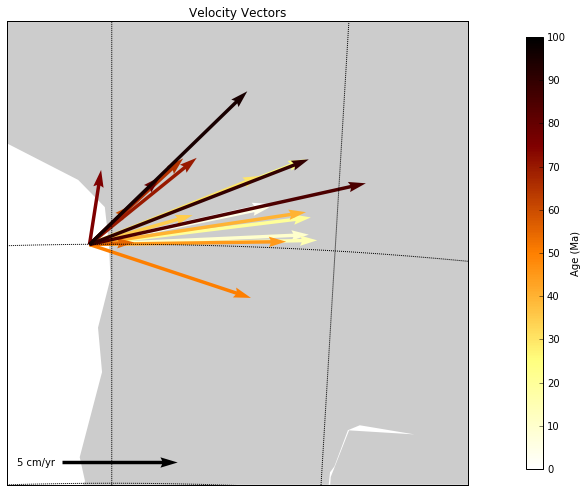

In [3]:

velocity_n = []
velocity_e = []

for time in time_array:
    # Get the rotation for current time interval, and the feature's reconstruction plate ID.
    equivalent_stage_rotation = rotation_model.get_rotation(
        time, moving_plate, time+time_step, fixed_plate)

    # Calculate a velocity for each reconstructed point over the 1My time interval.
    velocity_vector = pygplates.calculate_velocities(
        velocity_point,
        equivalent_stage_rotation,
        time_step,
        pygplates.VelocityUnits.cms_per_yr)

    velocity_n_e = pygplates.LocalCartesian.convert_from_geocentric_to_north_east_down(
                            velocity_point,
                            velocity_vector)

    velocity_n.append(velocity_n_e[0].get_y())
    velocity_e.append(velocity_n_e[0].get_x())


from mpl_toolkits.basemap import Basemap
from mpltools import color
import matplotlib as mpl

%matplotlib inline

# create figure, add axes
fig1 = plt.figure(figsize=(8,10))
ax = fig1.add_axes([0,0,0.8,1.0])
ax_cbr1 = fig1.add_axes([0.9,0.2,0.03,0.6])

m = Basemap(llcrnrlon=-75, llcrnrlat=-30., urcrnrlon=-55, urcrnrlat=-10,
            projection='lcc', lat_1=-10., lat_2=-30., lat_0=-20, lon_0=-70.,
            ax=ax)
m.fillcontinents(zorder=1)
m.drawparallels(np.arange(-80.,90,10.))
m.drawmeridians(np.arange(0.,360.,10.))

for vn,ve,age in zip(velocity_n,velocity_e,time_array):
    uproj,vproj,xx,yy = \
    m.rotate_vector(np.asarray(vn),
                    np.asarray(ve),
                    np.asarray(point_longitude),
                    np.asarray(point_latitude),returnxy=True)
    color = plt.cm.afmhot_r(age/max_time)
    Q = m.quiver(xx,yy,uproj,vproj,scale=20,zorder=2,color=color)

# make quiver key.
qk = plt.quiverkey(Q, 0.12, 0.05, 5, '5 cm/yr', labelpos='W',zorder=2,color='k')

# add colorbars for LIP Age and seismic velocity
norm = mpl.colors.Normalize(vmin=0, vmax=max_time)
cb1 = mpl.colorbar.ColorbarBase(ax_cbr1, cmap=plt.cm.afmhot_r,
                                   norm=norm)
cb1.set_label('Age (Ma)')

# set plot title
ax.set_title('Velocity Vectors')
plt.show()
